In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm

import datetime as dt

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title('Bitcoin Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

In [2]:
%%time

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options():
    import urllib.request, json
    url =  "https://test.deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]
    
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')
    
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

# Loop through all filtered options to get the current 'ticker' datas
def get_all_option_data():
    option_data = get_tick_data('BTC-PERPETUAL')
    options = filter_options(option_data['last_price'][0], get_all_active_options())
    for o in options.index:
        option_data = option_data.append(get_tick_data(o))
    return option_data

option_data = get_all_option_data()### Add additional metrics to dataoption_data['t'] = np.nan; option_data['strike'] = np.nan
# Calculated days until expiration
option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
# Pull strike from instrument name
option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
# Calculate "moneyness"
option_data['m'] = np.log(option_data['last_price'][0]/option_data['strike'])

500 active options.
144 active options after filter.
CPU times: user 1.65 s, sys: 12.2 ms, total: 1.66 s
Wall time: 51.3 s


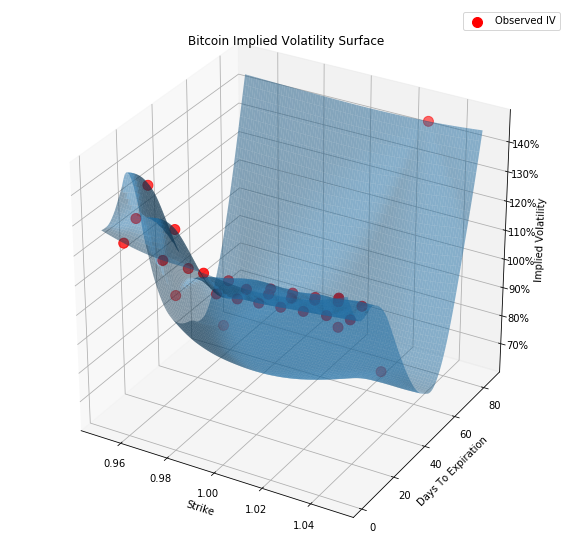

In [3]:
# Interpolate implied volatility using a cubic spline
# Then plot the implied volatility surface

option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['t']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))

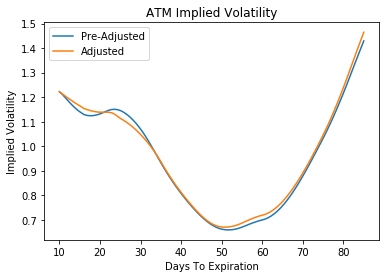

In [5]:
price_diff = option_data['mark_price'][0]-option_data['underlying_price']
option_data['iv_adj'] = option_data['mark_iv']+(option_data['greeks.delta']*price_diff)/(option_data['greeks.vega'])
option_data_ = option_data.iloc[1:].sort_values(['t','strike']).query('t>0')

Z = interpolate.griddata(np.array([x,y]).T,np.array(option_data_['iv_adj']/100),(X,Y), method='cubic')
iv_df_adj = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))
iv_df.loc[:,1].plot(label='Pre-Adjusted')
(iv_df_adj.loc[:,1]).plot(label='Adjusted')
plt.xlabel('Days To Expiration')
plt.ylabel('Implied Volatility')
plt.legend()
plt.title('ATM Implied Volatility')
plt.show()